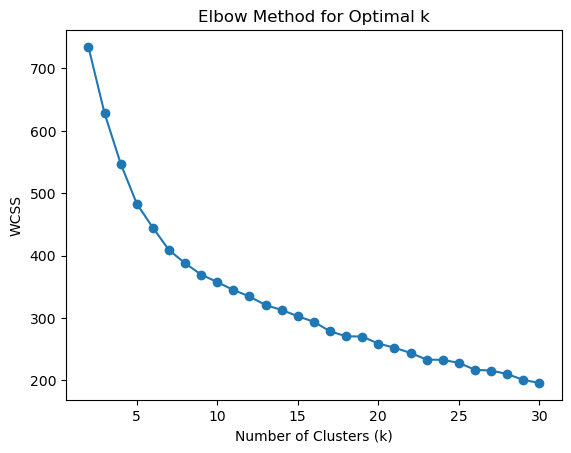

/Users/sparsh/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


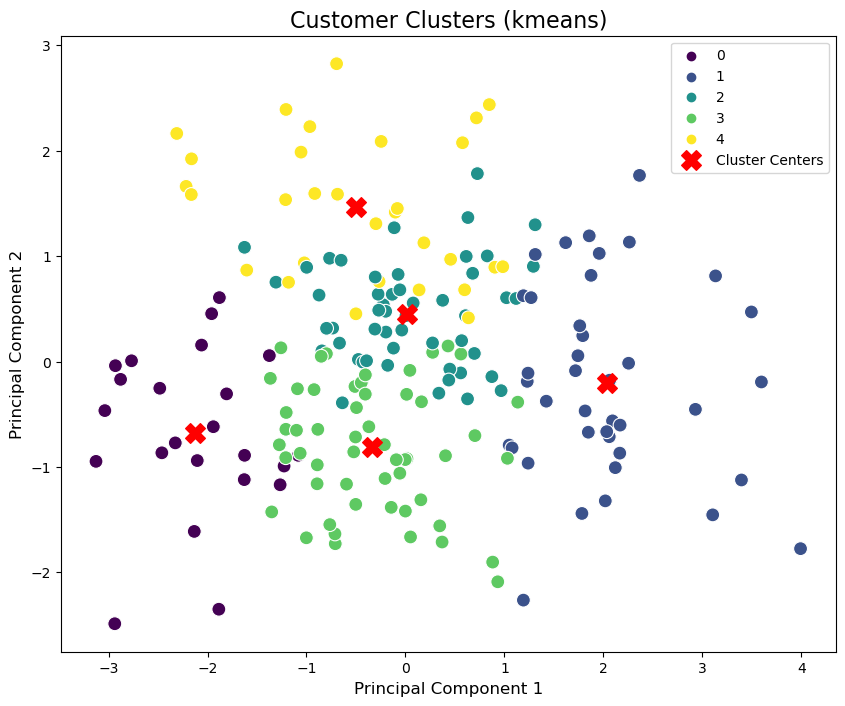

Cluster assignments saved to Customer_Clusters.csv.


In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

# Load datasets
def load_datasets():
    customers = pd.read_csv("Customers.csv")
    products = pd.read_csv("Products.csv")
    transactions = pd.read_csv("Transactions.csv")
    return customers, products, transactions

# Preprocess data
def preprocess_data(customers, products, transactions):
    # Convert date columns to datetime objects
    customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
    transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

    # Merge datasets to create a combined dataset
    combined_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

    # Calculate customer-level transaction metrics
    customer_metrics = combined_data.groupby('CustomerID').agg(
        AvgTransactionValue=('TotalValue', 'mean'),
        TotalQuantity=('Quantity', 'sum'),
        NumTransactions=('TransactionID', 'count')
    ).reset_index()

    # Calculate the number of days since the first signup date
    first_signup_date = customers['SignupDate'].min()
    customer_metrics['SignupDays'] = (customer_metrics['CustomerID'].map(customers.set_index('CustomerID')['SignupDate']) - first_signup_date).dt.days

    # Calculate customer category preferences
    category_pivot = combined_data.groupby(['CustomerID', 'Category']).size().reset_index(name='Count')
    category_pivot = category_pivot.pivot(index='CustomerID', columns='Category', values='Count').fillna(0)

    # Normalize to get the proportion of each category purchased by the customer
    category_pivot = category_pivot.div(category_pivot.sum(axis=1), axis=0).reset_index()

    # Merge all customer features
    customer_data = customer_metrics.merge(category_pivot, on='CustomerID', how='left').fillna(0)
    customer_data = customer_data.merge(customers[['CustomerID', 'Region']], on='CustomerID', how='left')

    # Define feature groups
    numerical_features = ['SignupDays', 'AvgTransactionValue', 'TotalQuantity', 'NumTransactions']
    categorical_features = ['Region']
    category_features = list(category_pivot.columns[1:])  # Exclude 'CustomerID'
    all_features = numerical_features + categorical_features + category_features

    # Preprocessor for scaling and encoding
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        ],
        remainder='passthrough'  # Keep category features
    )

    # Apply preprocessing
    processed_features = preprocessor.fit_transform(customer_data[all_features])

    # Create DataFrame with processed features
    processed_features_df = pd.DataFrame(
        processed_features,
        columns=preprocessor.get_feature_names_out(),
        index=customer_data['CustomerID']
    )

    return processed_features_df, customer_data

# Function to determine optimal number of clusters using Elbow method
def find_optimal_clusters(data, max_clusters=30):
    wcss = []
    for i in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    plt.plot(range(2, max_clusters + 1), wcss, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.show()

# Function to evaluate clusters
def evaluate_clusters(data, labels):
    db_index = davies_bouldin_score(data, labels)
    silhouette = silhouette_score(data, labels)
    print(f'Davies-Bouldin Index: {db_index:.3f}')
    print(f'Silhouette Score: {silhouette:.3f}')
    return db_index, silhouette

from sklearn.decomposition import PCA

def plot_customers_by_cluster(data, labels, n_clusters, algorithm):
    """
    Visualize customers by cluster.
    
    Args:
        data (array-like): Preprocessed feature data.
        labels (array-like): Cluster labels for each customer.
        n_clusters (int): Number of clusters.
        algorithm (str): Name of the clustering algorithm.
    """
    # Add labels to the original customer data
    customer_data['Cluster'] = labels

    # Reduce dimensions using PCA for visualization
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(data)

    # Create a DataFrame with reduced dimensions and cluster labels
    plot_data = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
    plot_data['Cluster'] = labels
    plot_data['CustomerID'] = customer_data['CustomerID'].values

    # Plot the clusters
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=plot_data, x='PCA1', y='PCA2', hue='Cluster', palette='viridis', s=100)
    plt.title(f'Customer Clusters ({algorithm})', fontsize=16)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)

    # Add cluster centers if K-Means
    if algorithm == 'kmeans':
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(data)
        centers = pca.transform(kmeans.cluster_centers_)
        plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label='Cluster Centers')
        plt.legend()

    plt.show()


# Function to perform clustering using a selected algorithm
def perform_clustering(data, algorithm, **kwargs):
    if algorithm == 'kmeans':
        model = KMeans(**kwargs)
    elif algorithm == 'hierarchical':
        model = AgglomerativeClustering(**kwargs)
    elif algorithm == 'dbscan':
        model = DBSCAN(**kwargs)
    else:
        raise ValueError("Unsupported clustering algorithm. Choose from 'kmeans', 'hierarchical', or 'dbscan'.")

    labels = model.fit_predict(data)
    return labels

def save_cluster_assignments(customer_data, labels, output_file="Customer_Clusters.csv"):
    """
    Save customer IDs along with their cluster assignments to a CSV file.
    
    Args:
        customer_data (pd.DataFrame): DataFrame containing customer information.
        labels (array-like): Cluster labels for each customer.
        output_file (str): Name of the output CSV file.
    """
    # Add cluster labels to the customer data
    customer_data['Cluster'] = labels

    # Select only the CustomerID and Cluster columns for output
    cluster_assignments = customer_data[['CustomerID', 'Cluster']]

    # Save to CSV
    cluster_assignments.to_csv(output_file, index=False)
    print(f"Cluster assignments saved to {output_file}.")


# Main execution
# Main execution
if __name__ == "__main__":
    customers, products, transactions = load_datasets()
    processed_features, customer_data = preprocess_data(customers, products, transactions)

    # Determine optimal number of clusters using Elbow method
    find_optimal_clusters(processed_features)  # Add this line to show the graph

    # Perform K-Means clustering
    kmeans_labels = perform_clustering(processed_features, 'kmeans', n_clusters=5, init='k-means++', random_state=42, n_init=10)

    # Plot customers by cluster
    plot_customers_by_cluster(processed_features, kmeans_labels, n_clusters=5, algorithm='kmeans')  # Add this line to show the clustered graph

    # Save cluster assignments to a CSV file
    save_cluster_assignments(customer_data, kmeans_labels, output_file="Customer_Clusters.csv")